In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,accuracy_score

In [2]:
import xgboost as xgb

In [3]:
import matplotlib
%matplotlib inline 
matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,75)

In [4]:
class evaluation:
    def __init__(self, true_s):
        self.true_df = pd.DataFrame(true_s)
        self.true_df.columns = ['swell']
        self.true_df['swell(t+1)'] = self.true_df['swell'].shift(-1)
        self.true_df['swell(t+2)'] = self.true_df['swell'].shift(-2)
        self.true_df['swell(t-1)'] = self.true_df['swell'].shift(1)
        self.true_df['swell(t-2)'] = self.true_df['swell'].shift(2)
    
        self.swell_columns = ['swell(t+1)','swell(t+2)','swell(t-1)','swell(t-2)']
    
    def _eval_one(self, pred):
        true = self.true_df.loc[pred.name]
        swell = true['swell'] 
        p_swell = pred['pred']

        if swell == 0 and p_swell == 0:
            return 1

        if swell == 1 and p_swell == 1:
            return 2

        if swell == 0 and p_swell == 1:
            if (true[self.swell_columns].values == 1).any():
                return 0
            else:
                return -1

        if swell == 1 and p_swell == 0:
            if (pred[self.swell_columns].values == 1).any():
                return 0
            else: 
                return -2
    
    def evaluate(self, pred):
        pred_df = pd.DataFrame(pred)
        pred_df.columns = ['pred']
        pred_df['swell(t+1)'] = pred_df['pred'].shift(-1)
        pred_df['swell(t+2)'] = pred_df['pred'].shift(-2)
        pred_df['swell(t-1)'] = pred_df['pred'].shift(1)
        pred_df['swell(t-2)'] = pred_df['pred'].shift(2)

        result = []
        for index in pred_df.index:
            result.append(self._eval_one(pred_df.loc[index]))
        
        #print(result)
        print(pd.Series(result).value_counts())
        
        #print(result)
        return np.sum(result)

In [5]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 90 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_일시                 33979 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_일시                 19639 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 no

In [6]:
df.drop([col for col in df.columns if '일시' in col],axis=1,inplace=True)

In [7]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [8]:
df['swell'] = df['swell'] + df['weather_deterioration']

In [9]:
df['swell'].value_counts()

0.0    26863
1.0     4937
2.0     2592
Name: swell, dtype: int64

In [10]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [11]:
# # 음력 추가
# from korean_lunar_calendar import KoreanLunarCalendar
# from datetime import datetime

# def add_lunar_date(df):
#     calendar = KoreanLunarCalendar()
    
#     lunar_y = []
#     lunar_m = []
#     lunar_d = []
#     for y, m, d in zip (df['year'], df['month'], df['day']):
#         calendar.setSolarDate(y, m, d)
#         lunar_date = calendar.LunarIsoFormat()
#         lunar_y.append(int(lunar_date[:4]))
#         lunar_m.append(int(lunar_date[5:7]))
#         lunar_d.append(int(lunar_date[8:10]))
        
#     df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d


In [12]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['weekday'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [13]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    #df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    #df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    #df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    
    #df.drop(['month', 'lunar_month'], axis=1, inplace=True)
    df.drop(['month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    #df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    #df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    #df.drop(['day', 'lunar_day'], axis=1, inplace=True)
    df.drop(['day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    df.drop(['weekday'],axis=1,inplace=True)
    df.drop(['week'],axis=1,inplace=True)

In [14]:
# %%time
# add_lunar_date(df)

In [15]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [16]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [17]:
s[s > 10].index.tolist()[0]

20170315

In [18]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [19]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [20]:
get_prev_date('20170101')

'2016123100'

In [21]:
get_today_from_07('20170101')

'2017010100'

In [22]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [23]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    day = get_prev_date(d)
    #day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

2017031400 2017031500
2017121000 2017121100
2016112900 2016113000
2017033000 2017033100
2014102200 2014102300
2016101900 2016102000
2014051700 2014051800
2017021100 2017021200
2015071700 2015071800
2014070500 2014070600
2015062600 2015062700
2016082900 2016083000
2017102200 2017102300
2017101100 2017101200
2014122000 2014122100
2017091500 2017091600
2016012100 2016012200
2015040300 2015040400
2015011200 2015011300
2014092400 2014092500
2017060200 2017060300
2016122500 2016122600
2015121200 2015121300
2016030300 2016030400
2015111200 2015111300


600

In [24]:
df['swell(t+1)'] = df['swell'].shift(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 92 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 non-null float64
21229_수온(°C)             34629 non-null float64
21229_습도(%)              33939 no

### add_seqeunce

In [25]:
inseq = 6
sequnce_features = df.columns.drop(['hour','climate', 'weather_deterioration', 'swell','day_hour', 'year',
       'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'weekday_sin',
       'weekday_cos', 'swell(t+1)']).tolist()

In [26]:
temp_cols = []
temp_names = []
for i in range(1,inseq):
    temp_cols.append(df[sequnce_features].shift(i))
    temp_names += [feature_name+'(t-{})'.format(i) for feature_name in sequnce_features]

In [27]:
seq_df = pd.concat(temp_cols,axis=1)
seq_df.columns = temp_names

df = pd.concat([df,seq_df],axis=1).iloc[inseq+1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34985 entries, 7 to 34991
Columns: 487 entries, hour to 22189_파향(deg)(t-5)
dtypes: float64(483), int64(3), object(1)
memory usage: 130.3+ MB


In [28]:
def output_change(x):
    if x == 2:
        return 1
    else:
        return 0

In [29]:
df['hour'] = df['hour'].astype(str)
df['index'] = df.index
df.set_index('hour',inplace=True,)

In [30]:
df.columns

Index(['climate', 'weather_deterioration', 'swell', '22453_수온(°C)',
       '22453_최대파고(m)', '22453_유의파고(m)', '22453_평균파고(m)', '22453_파주기(sec)',
       '22490_수온(°C)', '22490_최대파고(m)',
       ...
       '22189_현지기압(hPa)(t-5)', '22189_습도(%)(t-5)', '22189_기온(°C)(t-5)',
       '22189_수온(°C)(t-5)', '22189_최대파고(m)(t-5)', '22189_유의파고(m)(t-5)',
       '22189_평균파고(m)(t-5)', '22189_파주기(sec)(t-5)', '22189_파향(deg)(t-5)',
       'index'],
      dtype='object', length=487)

### 테스트 데이터 하나당 feature selection을 수행

In [31]:
test_date_hour = sorted(test_date_hour)
test_date_hour

['2014051707',
 '2014051708',
 '2014051709',
 '2014051710',
 '2014051711',
 '2014051712',
 '2014051713',
 '2014051714',
 '2014051715',
 '2014051716',
 '2014051717',
 '2014051718',
 '2014051719',
 '2014051720',
 '2014051721',
 '2014051722',
 '2014051723',
 '2014051800',
 '2014051801',
 '2014051802',
 '2014051803',
 '2014051804',
 '2014051805',
 '2014051806',
 '2014070507',
 '2014070508',
 '2014070509',
 '2014070510',
 '2014070511',
 '2014070512',
 '2014070513',
 '2014070514',
 '2014070515',
 '2014070516',
 '2014070517',
 '2014070518',
 '2014070519',
 '2014070520',
 '2014070521',
 '2014070522',
 '2014070523',
 '2014070600',
 '2014070601',
 '2014070602',
 '2014070603',
 '2014070604',
 '2014070605',
 '2014070606',
 '2014092407',
 '2014092408',
 '2014092409',
 '2014092410',
 '2014092411',
 '2014092412',
 '2014092413',
 '2014092414',
 '2014092415',
 '2014092416',
 '2014092417',
 '2014092418',
 '2014092419',
 '2014092420',
 '2014092421',
 '2014092422',
 '2014092423',
 '2014092500',
 '20140925

In [32]:
notna_df = df.loc[test_date_hour[:24]]['swell(t+1)']
notna_df

hour
2014051707    0.0
2014051708    0.0
2014051709    0.0
2014051710    0.0
2014051711    0.0
2014051712    2.0
2014051713    2.0
2014051714    2.0
2014051715    2.0
2014051716    2.0
2014051717    2.0
2014051718    2.0
2014051719    2.0
2014051720    2.0
2014051721    2.0
2014051722    2.0
2014051723    2.0
2014051800    2.0
2014051801    2.0
2014051802    2.0
2014051803    2.0
2014051804    2.0
2014051805    2.0
2014051806    NaN
Name: swell(t+1), dtype: float64

In [33]:
df.loc[:test_date_hour[3]]['swell(t+1)'].value_counts()

0.0    2407
1.0     514
2.0     268
Name: swell(t+1), dtype: int64

### col 중 20% 이상의 미싱벨류가 있는 경우 삭제

In [34]:
drop_features = ['swell(t+1)','swell','weather_deterioration','index','climate']

In [35]:
test_date = test_date_hour[:24]
test_date

['2014051707',
 '2014051708',
 '2014051709',
 '2014051710',
 '2014051711',
 '2014051712',
 '2014051713',
 '2014051714',
 '2014051715',
 '2014051716',
 '2014051717',
 '2014051718',
 '2014051719',
 '2014051720',
 '2014051721',
 '2014051722',
 '2014051723',
 '2014051800',
 '2014051801',
 '2014051802',
 '2014051803',
 '2014051804',
 '2014051805',
 '2014051806']

In [36]:
all_df = df.loc[:test_date[-1]]#.drop(drop_features,axis=1)
all_df.tail(10)

,climate,weather_deterioration,swell,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),22490_수온(°C),22490_최대파고(m),...,22189_현지기압(hPa)(t-5),22189_습도(%)(t-5),22189_기온(°C)(t-5),22189_수온(°C)(t-5),22189_최대파고(m)(t-5),22189_유의파고(m)(t-5),22189_평균파고(m)(t-5),22189_파주기(sec)(t-5),22189_파향(deg)(t-5),index
hour,,,,,,,,,,,,,,,,,,,,,
2014051721,7.0,1,2.0,17.7,1.3,1.0,0.6,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3206
2014051722,7.0,1,2.0,17.3,1.5,1.2,0.7,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3207
2014051723,7.0,1,2.0,17.0,1.4,1.1,0.7,8.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3208
2014051800,7.0,1,2.0,17.0,1.6,1.2,0.7,9.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3209
2014051801,7.0,1,2.0,17.0,1.5,1.1,0.7,8.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3210
2014051802,5.0,1,2.0,16.7,1.8,1.2,0.8,8.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3211
2014051803,5.0,1,2.0,16.5,1.5,1.2,0.7,8.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3212
2014051804,5.0,1,2.0,16.4,1.2,1.1,0.7,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3213
2014051805,5.0,1,2.0,16.3,1.2,1.0,0.6,8.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3214


In [37]:
all_size = len(all_df)
col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.1)
possible_cols = col_df[col_df[0]==True].index.tolist()
possible_cols

['climate',
 'weather_deterioration',
 'swell',
 '22453_수온(°C)',
 '22453_최대파고(m)',
 '22453_유의파고(m)',
 '22453_평균파고(m)',
 '22453_파주기(sec)',
 '21229_GUST풍속 1(m/s)',
 '21229_기온(°C)',
 '21229_수온(°C)',
 '21229_습도(%)',
 '21229_유의파고(m)',
 '21229_최대파고(m)',
 '21229_파주기(sec)',
 '21229_파향(deg)',
 '21229_평균파고(m)',
 '21229_풍속1(m/s)',
 '21229_풍향1(deg)',
 '21229_현지기압(hPa)',
 '22105_GUST풍속 1(m/s)',
 '22105_기온(°C)',
 '22105_수온(°C)',
 '22105_습도(%)',
 '22105_유의파고(m)',
 '22105_최대파고(m)',
 '22105_파주기(sec)',
 '22105_파향(deg)',
 '22105_평균파고(m)',
 '22105_풍속1(m/s)',
 '22105_풍향1(deg)',
 '22106_GUST풍속 1(m/s)',
 '22106_기온(°C)',
 '22106_수온(°C)',
 '22106_습도(%)',
 '22106_유의파고(m)',
 '22106_최대파고(m)',
 '22106_파주기(sec)',
 '22106_파향(deg)',
 '22106_평균파고(m)',
 '22106_풍속1(m/s)',
 '22106_풍향1(deg)',
 '22106_현지기압(hPa)',
 'day_hour',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'weekday_sin',
 'weekday_cos',
 'swell(t+1)',
 '22453_수온(°C)(t-1)',
 '22453_최대파고(m)(t-1)',
 '22453_유의파고(m)(t-1)',
 '22453_평균파고(m)(t-1)',
 

In [38]:
possible_df = all_df[possible_cols].copy()
possible_df.tail()
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3209 entries, 2014010414 to 2014051806
Columns: 253 entries, climate to index
dtypes: float64(249), int64(3), object(1)
memory usage: 6.2+ MB


In [39]:
possible_df.tail()

,climate,weather_deterioration,swell,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),...,22106_습도(%)(t-5),22106_유의파고(m)(t-5),22106_최대파고(m)(t-5),22106_파주기(sec)(t-5),22106_파향(deg)(t-5),22106_평균파고(m)(t-5),22106_풍속1(m/s)(t-5),22106_풍향1(deg)(t-5),22106_현지기압(hPa)(t-5),index
hour,,,,,,,,,,,,,,,,,,,,,
2014051802,5.0,1,2.0,16.7,1.8,1.2,0.8,8.6,2.4,15.1,...,88.0,1.8,2.7,10.7,214.0,1.3,1.5,140.0,1013.2,3211
2014051803,5.0,1,2.0,16.5,1.5,1.2,0.7,8.6,1.7,15.0,...,88.0,1.8,2.5,9.1,214.0,1.3,0.1,166.0,1013.6,3212
2014051804,5.0,1,2.0,16.4,1.2,1.1,0.7,8.4,2.3,15.1,...,88.0,1.7,2.8,10.7,0.0,1.2,0.9,120.0,1013.7,3213
2014051805,5.0,1,2.0,16.3,1.2,1.0,0.6,8.2,1.5,15.0,...,88.0,1.8,2.8,10.7,209.0,1.3,0.9,185.0,1014.1,3214
2014051806,5.0,1,2.0,16.2,1.0,0.8,0.5,7.8,2.0,15.0,...,87.0,1.7,2.8,10.7,214.0,1.2,0.0,0.0,1014.0,3215


In [40]:
possible_df.fillna(method='ffill',inplace=True)
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3209 entries, 2014010414 to 2014051806
Columns: 253 entries, climate to index
dtypes: float64(249), int64(3), object(1)
memory usage: 6.2+ MB


In [41]:
train_X = possible_df.iloc[:-25].drop(drop_features,axis=1)
train_X.tail()

,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),21229_유의파고(m),...,22106_수온(°C)(t-5),22106_습도(%)(t-5),22106_유의파고(m)(t-5),22106_최대파고(m)(t-5),22106_파주기(sec)(t-5),22106_파향(deg)(t-5),22106_평균파고(m)(t-5),22106_풍속1(m/s)(t-5),22106_풍향1(deg)(t-5),22106_현지기압(hPa)(t-5)
hour,,,,,,,,,,,,,,,,,,,,,
2014051701,16.2,1.1,0.9,0.6,8.6,3.1,15.2,15.3,73.0,2.1,...,16.7,67.0,1.0,1.7,8.0,231.0,0.7,3.1,51.0,1009.3
2014051702,16.3,1.1,0.8,0.5,8.1,4.1,15.1,14.9,73.0,1.9,...,16.4,74.0,1.1,1.6,9.1,225.0,0.7,2.3,45.0,1010.0
2014051703,16.4,1.5,1.0,0.6,8.8,4.9,15.0,15.0,72.0,2.3,...,16.3,72.0,1.3,1.8,9.1,213.0,0.9,2.9,40.0,1010.8
2014051704,16.3,1.1,0.9,0.5,8.3,3.4,15.1,15.0,74.0,2.2,...,16.4,76.0,1.6,2.1,9.1,195.0,1.1,1.9,47.0,1011.2
2014051705,16.3,1.0,0.7,0.5,8.3,5.5,14.8,14.9,74.0,2.1,...,16.6,75.0,1.4,1.8,9.1,198.0,1.0,1.1,2.0,1011.8


In [42]:
train_y = possible_df.iloc[:-25]['swell(t+1)']
print(train_y.value_counts())
train_y.tail()

0.0    2402
1.0     514
2.0     268
Name: swell(t+1), dtype: int64


hour
2014051701    0.0
2014051702    0.0
2014051703    0.0
2014051704    0.0
2014051705    0.0
Name: swell(t+1), dtype: float64

In [43]:
test_X = pd.DataFrame(possible_df.iloc[-25:-1])\
                .drop(drop_features,axis=1)
test_X

,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),21229_유의파고(m),...,22106_수온(°C)(t-5),22106_습도(%)(t-5),22106_유의파고(m)(t-5),22106_최대파고(m)(t-5),22106_파주기(sec)(t-5),22106_파향(deg)(t-5),22106_평균파고(m)(t-5),22106_풍속1(m/s)(t-5),22106_풍향1(deg)(t-5),22106_현지기압(hPa)(t-5)
hour,,,,,,,,,,,,,,,,,,,,,
2014051706,16.4,1.1,0.9,0.6,8.8,5.2,14.7,14.7,77.0,2.0,...,17.1,80.0,2.1,3.1,9.1,201.0,1.5,1.3,356.0,1011.7
2014051707,16.3,1.2,0.9,0.5,8.6,6.1,14.7,14.7,76.0,1.9,...,16.9,82.0,1.4,2.2,8.0,201.0,1.0,0.2,264.0,1011.9
2014051708,16.3,1.3,0.8,0.5,8.2,6.1,14.7,14.8,77.0,2.2,...,16.8,84.0,1.5,2.2,9.1,0.0,1.1,0.4,29.0,1011.7
2014051709,16.5,1.1,0.8,0.5,8.3,5.5,14.6,15.2,77.0,2.4,...,17.1,76.0,1.4,2.0,8.0,211.0,1.0,0.7,96.0,1011.7
2014051710,16.5,1.1,0.8,0.5,8.3,5.0,14.8,15.5,77.0,2.0,...,17.1,75.0,1.9,2.5,9.1,209.0,1.3,1.4,187.0,1011.8
2014051711,16.8,1.1,0.9,0.6,9.0,4.1,14.9,15.6,78.0,2.4,...,16.8,75.0,1.7,2.7,9.1,200.0,1.2,2.5,153.0,1012.0
2014051712,17.5,1.1,0.9,0.5,8.8,4.4,15.0,15.8,78.0,2.2,...,16.9,73.0,1.6,2.4,8.0,212.0,1.1,3.4,144.0,1012.2
2014051713,17.5,1.0,0.8,0.5,9.1,5.7,15.3,16.0,78.0,2.1,...,17.0,76.0,1.8,2.5,8.0,204.0,1.3,3.4,158.0,1012.3
2014051714,18.4,1.0,0.9,0.5,10.0,5.7,15.4,16.0,80.0,2.2,...,17.1,76.0,1.5,2.8,9.1,209.0,1.1,2.6,171.0,1012.7


In [44]:
test_y = pd.DataFrame(possible_df.iloc[-24:])\
                ['swell']
test_y

hour
2014051707    0.0
2014051708    0.0
2014051709    0.0
2014051710    0.0
2014051711    0.0
2014051712    0.0
2014051713    2.0
2014051714    2.0
2014051715    2.0
2014051716    2.0
2014051717    2.0
2014051718    2.0
2014051719    2.0
2014051720    2.0
2014051721    2.0
2014051722    2.0
2014051723    2.0
2014051800    2.0
2014051801    2.0
2014051802    2.0
2014051803    2.0
2014051804    2.0
2014051805    2.0
2014051806    2.0
Name: swell, dtype: float64

In [45]:
model = RandomForestClassifier(n_estimators=150,n_jobs=4)
model.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [46]:
pred = model.predict_proba(test_X)

In [47]:
pred, np.apply_along_axis(np.argmax,1,pred).tolist(), test_y.tolist()

(array([[ 0.70666667,  0.14      ,  0.15333333],
        [ 0.70666667,  0.12666667,  0.16666667],
        [ 0.69333333,  0.10666667,  0.2       ],
        [ 0.72      ,  0.06      ,  0.22      ],
        [ 0.62      ,  0.07333333,  0.30666667],
        [ 0.64666667,  0.05333333,  0.3       ],
        [ 0.56666667,  0.06      ,  0.37333333],
        [ 0.58      ,  0.07333333,  0.34666667],
        [ 0.52666667,  0.1       ,  0.37333333],
        [ 0.54      ,  0.14      ,  0.32      ],
        [ 0.54666667,  0.11333333,  0.34      ],
        [ 0.56      ,  0.13333333,  0.30666667],
        [ 0.53333333,  0.12666667,  0.34      ],
        [ 0.52666667,  0.17333333,  0.3       ],
        [ 0.54666667,  0.19333333,  0.26      ],
        [ 0.61333333,  0.18666667,  0.2       ],
        [ 0.58      ,  0.22      ,  0.2       ],
        [ 0.55333333,  0.24666667,  0.2       ],
        [ 0.62      ,  0.22666667,  0.15333333],
        [ 0.6       ,  0.22666667,  0.17333333],
        [ 0.62      

In [48]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
train_X.columns[indices].tolist()

['22453_평균파고(m)(t-1)',
 '22106_습도(%)(t-1)',
 '22106_습도(%)',
 '22453_평균파고(m)',
 '22106_습도(%)(t-2)',
 '22453_최대파고(m)(t-2)',
 '22453_평균파고(m)(t-2)',
 '22453_최대파고(m)(t-1)',
 '22453_유의파고(m)(t-1)',
 '22453_최대파고(m)(t-5)']

In [49]:
%%time

model_scores = []
imp_features = []
preds = [] 
probas = []

for i in range(25):
    st = time.time()
    index = i*24
    test_date = test_date_hour[index:index+24]
    all_df = df.loc[:test_date[-1]]
   
    all_size = len(all_df)
    col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.1)
    possible_cols = col_df[col_df[0]==True].index.tolist()
    possible_df = all_df[possible_cols].copy()
    possible_df.fillna(method='ffill',inplace=True)
    
    train_X = possible_df.iloc[:-25].drop(drop_features,axis=1)
    train_y = possible_df.iloc[:-25]['swell(t+1)']
    
    test_X = pd.DataFrame(possible_df.iloc[-25:-1])\
                .drop(drop_features,axis=1)
        
    test_y = pd.DataFrame(possible_df.iloc[-24:])\
                ['swell']
    
#     model = RandomForestClassifier(n_estimators=500,n_jobs=4,class_weight='balanced_subsample')
#     model.fit(train_X,train_y)

    model = xgb.XGBClassifier(n_estimators=200,learning_rate=0.1)
    model = model.fit(train_X,train_y)
    pred = model.predict_proba(test_X)
    
    preds.append(np.apply_along_axis(np.argmax,1,pred).tolist())
    probas.extend(pred.tolist())

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    imp_features.append(train_X.columns[indices].tolist())

    print(i,'train {} ~ {} size: {}, test {}, {} sec'\
               .format(train_X.index.tolist()[0],train_X.index.tolist()[-1], len(train_X),test_X.index.tolist()[0],round(time.time()-st,2)))
    print(preds[-1])
    print(list(map(int,test_y.tolist())))

0 train 2014010414 ~ 2014051705 size: 3184, test 2014051706, 18.93 sec
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
1 train 2014010414 ~ 2014070505 size: 4360, test 2014070506, 23.58 sec
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 train 2014010414 ~ 2014092405 size: 6304, test 2014092406, 33.91 sec
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
3 train 2014010414 ~ 2014102205 size: 6976, test 2014102206, 36.35 sec
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
4 train 2014010414 ~ 2014122005 size: 8392, test 2014122006, 41.31 sec
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [50]:
pred_hour = []
proba_hour_temp = []
for pred in preds:
    pred_hour.extend(pred)

# for proba in probas:
#     #print(proba.tolist())
#     print(type(proba.tolist()))
#     for prob in proba.tolist():
#         proba_hour_temp.append(np.array(prob))

In [51]:
test = df.loc[test_date_hour][['swell']]
test['pred'] = pred_hour
test['proba_swell'] = np.asarray(probas)[:,1]
test['proba_no_swell'] = np.asarray(probas)[:,0]

In [52]:
test

,swell,pred,proba_swell,proba_no_swell
hour,,,,
2014051707,0.0,0,0.015215,0.975088
2014051708,0.0,0,0.024405,0.970288
2014051709,0.0,0,0.024613,0.969478
2014051710,0.0,0,0.017122,0.969353
2014051711,0.0,0,0.020058,0.934701
2014051712,0.0,0,0.022499,0.940722
2014051713,2.0,0,0.018473,0.970029
2014051714,2.0,0,0.023875,0.961632
2014051715,2.0,0,0.058162,0.923168


In [53]:
f1_score(test['pred'],test['swell'],average='weighted')

0.67490788473394181

In [54]:
f1_score(test['pred'],test['swell'])

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [55]:
accuracy_score(test['pred'],test['swell'])

0.73166666666666669

In [56]:
test['pred_swell'] = test['pred']#.apply(lambda x: output_change(x))
test['real_swell'] = test['swell']#.apply(lambda x: output_change(x))
test

,swell,pred,proba_swell,proba_no_swell,pred_swell,real_swell
hour,,,,,,
2014051707,0.0,0,0.006300,0.993700,0,0.0
2014051708,0.0,0,0.002796,0.997204,0,0.0
2014051709,0.0,0,0.008764,0.991236,0,0.0
2014051710,0.0,0,0.015030,0.984970,0,0.0
2014051711,0.0,0,0.069827,0.930173,0,0.0
2014051712,0.0,0,0.035468,0.964532,0,0.0
2014051713,1.0,0,0.033962,0.966038,0,1.0
2014051714,1.0,0,0.017222,0.982777,0,1.0
2014051715,1.0,0,0.011943,0.988057,0,1.0


In [57]:
test['pred_swell'].value_counts()

0    541
1     59
Name: pred_swell, dtype: int64

In [58]:
f1_score(test['pred_swell'],test['real_swell'],average='weighted')

0.78487469785321917

In [59]:
class2 = test[test['real_swell']==1]
accuracy_score(class2['real_swell'],class2['pred_swell'])

0.25

In [60]:
real = df.loc[test_date_hour]['swell'].fillna(method='ffill')
real

hour
2014051707    0.0
2014051708    0.0
2014051709    0.0
2014051710    0.0
2014051711    0.0
2014051712    0.0
2014051713    1.0
2014051714    1.0
2014051715    1.0
2014051716    1.0
2014051717    1.0
2014051718    1.0
2014051719    1.0
2014051720    1.0
2014051721    1.0
2014051722    1.0
2014051723    1.0
2014051800    1.0
2014051801    1.0
2014051802    1.0
2014051803    1.0
2014051804    1.0
2014051805    1.0
2014051806    1.0
2014070507    0.0
2014070508    0.0
2014070509    0.0
2014070510    0.0
2014070511    0.0
2014070512    0.0
             ... 
2017102301    0.0
2017102302    0.0
2017102303    0.0
2017102304    0.0
2017102305    0.0
2017102306    0.0
2017121007    0.0
2017121008    0.0
2017121009    0.0
2017121010    0.0
2017121011    0.0
2017121012    0.0
2017121013    0.0
2017121014    0.0
2017121015    0.0
2017121016    0.0
2017121017    0.0
2017121018    0.0
2017121019    0.0
2017121020    0.0
2017121021    0.0
2017121022    0.0
2017121023    0.0
2017121100    0.0
20171

In [61]:
def threshold_swell(proba):
    if proba > 0.2:
        return 1
    else:
        return 0

In [62]:
test['eval_swell'] = test['proba_swell'].apply(threshold_swell)
test['eval_swell'].value_counts()

0    444
1    156
Name: eval_swell, dtype: int64

In [63]:
test['pred_swell'].value_counts()

0    541
1     59
Name: pred_swell, dtype: int64

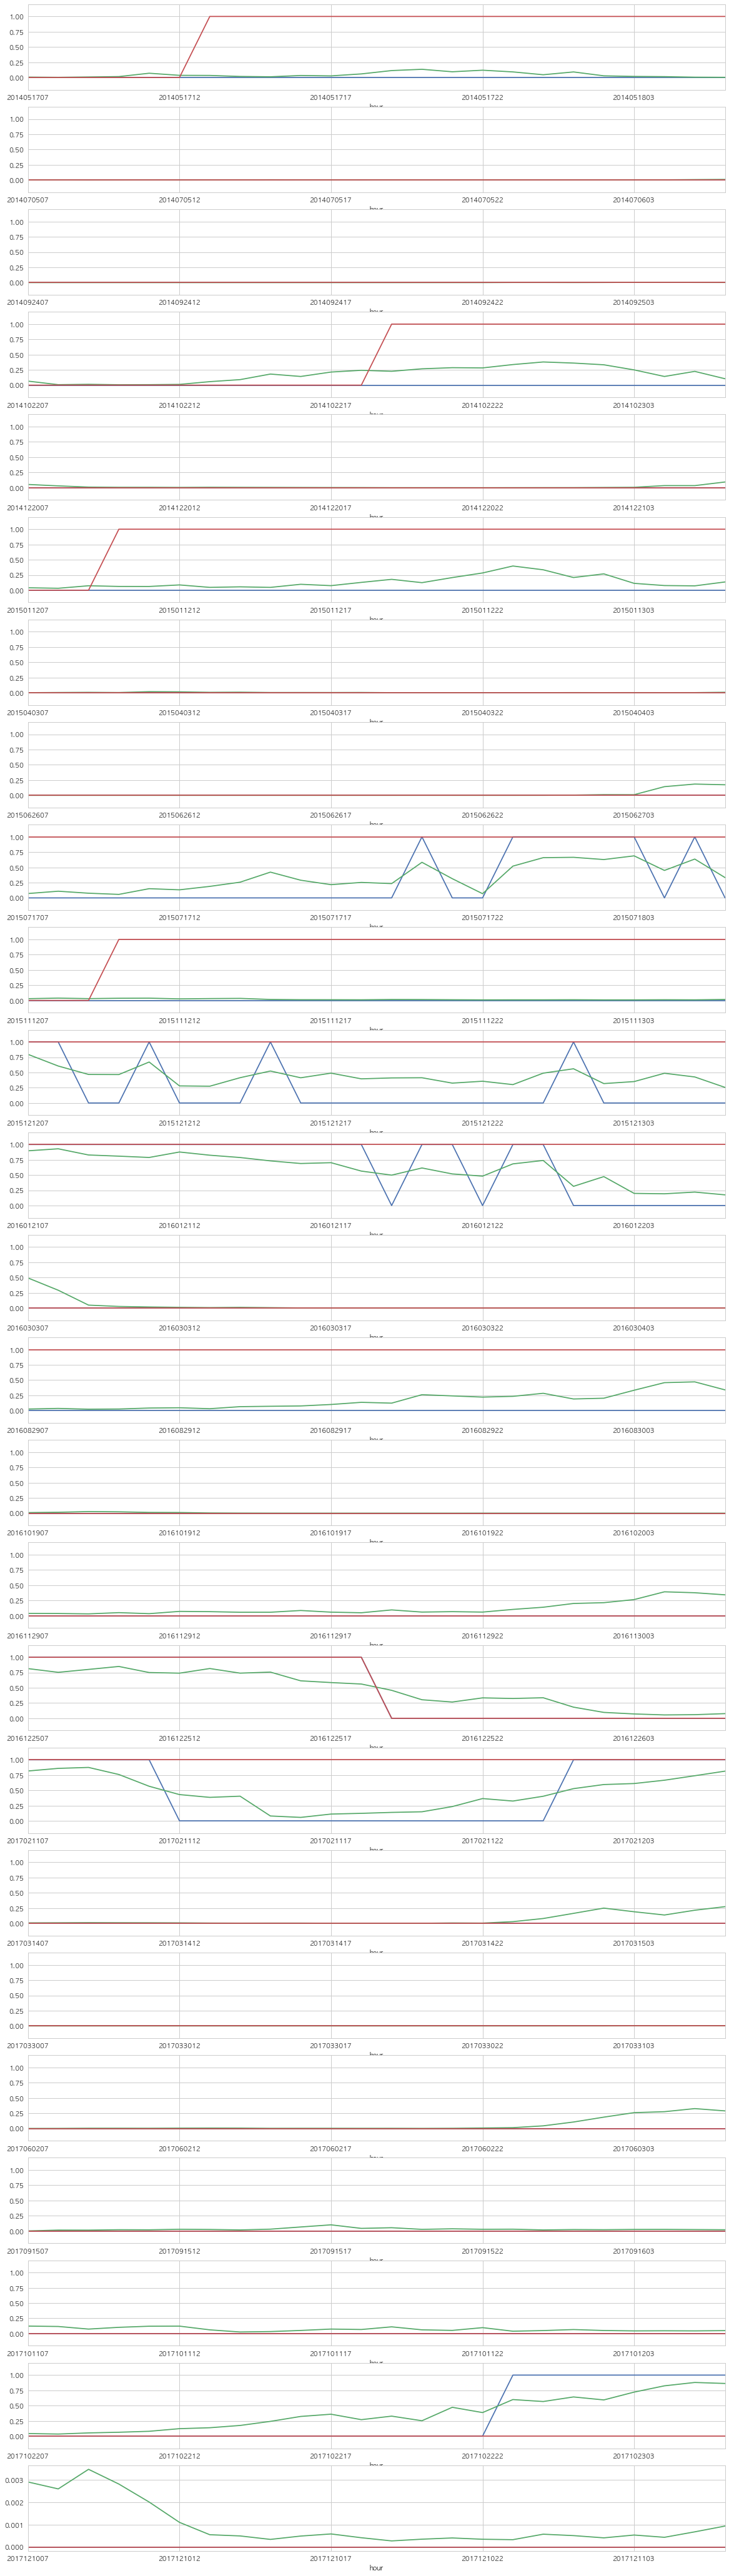

In [64]:
index = 0
for i in range(25):
    index = i*24
    plt.ylim(ymax=1.2,ymin=-0.2)
    plt.subplot(25,1,i+1)
    test.iloc[index:index+24]['pred_swell'].plot()
    #test.iloc[index:index+24]['eval_swell'].plot()
    test.iloc[index:index+24]['proba_swell'].plot()
    real.iloc[index:index+24].plot()#.apply(lambda x:output_change(x)).plot()

In [65]:
index=0
test.iloc[index:index+24].T

hour,2014051707,2014051708,2014051709,2014051710,2014051711,2014051712,2014051713,2014051714,2014051715,2014051716,...,2014051721,2014051722,2014051723,2014051800,2014051801,2014051802,2014051803,2014051804,2014051805,2014051806
swell,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
pred,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
proba_swell,0.0063,0.002796,0.008764,0.01503,0.069827,0.035468,0.033962,0.017222,0.011943,0.03305,...,0.093809,0.119464,0.09152,0.045192,0.091048,0.027544,0.017593,0.014159,0.005177,0.002845
proba_no_swell,0.9937,0.997204,0.991236,0.98497,0.930173,0.964532,0.966038,0.982777,0.988057,0.96695,...,0.906191,0.880536,0.90848,0.954808,0.908952,0.972457,0.982407,0.985841,0.994823,0.997155
pred_swell,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
real_swell,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
eval_swell,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
#eval_metric = evaluation(df['swell(t+1)'].apply(output_change))
eval_metric = evaluation(df['swell'].fillna(method='ffill'))

In [67]:
scores = []
for day in range(25):
    st = day*24
    print(st)
    scores.append(eval_metric.evaluate(test['eval_swell'].iloc[st:st + 24]))
    #print(test['pred_swell'][st:st+24].value_counts())

print(scores)

0
-2    18
 1     6
dtype: int64
24
1    24
dtype: int64
48
1    24
dtype: int64
72
2    10
1    10
0     4
dtype: int64
96
1    24
dtype: int64
120
-2    11
 2     6
 0     4
 1     3
dtype: int64
144
1    24
dtype: int64
168
1    24
dtype: int64
192
 2    16
-2     5
 0     3
dtype: int64
216
-2    21
 1     3
dtype: int64
240
2    24
dtype: int64
264
2    21
0     3
dtype: int64
288
1    22
0     2
dtype: int64
312
-2    11
 2    10
 0     3
dtype: int64
336
1    24
dtype: int64
360
 1    18
-1     6
dtype: int64
384
 2    12
 1     6
-1     4
 0     2
dtype: int64
408
 2    18
 0     4
-2     2
dtype: int64
432
 1    21
-1     3
dtype: int64
456
1    24
dtype: int64
480
 1    20
-1     4
dtype: int64
504
1    24
dtype: int64
528
1    24
dtype: int64
552
-1    16
 1     8
dtype: int64
576
1    24
dtype: int64
[-30, 24, 24, 30, 24, -7, 24, 24, 22, -39, 48, 42, 22, -2, 24, 12, 26, 32, 18, 24, 16, 24, 24, -8, 24]


In [68]:
np.sum(scores)

422

In [69]:
imp_features

[['day_cos',
  '22106_수온(°C)',
  '22106_풍향1(deg)(t-1)',
  '21229_수온(°C)(t-3)',
  '22106_습도(%)',
  '22105_수온(°C)(t-2)',
  '22453_파주기(sec)(t-5)',
  '21229_최대파고(m)',
  '22106_기온(°C)',
  '22106_유의파고(m)(t-4)'],
 ['day_cos',
  '22105_수온(°C)(t-5)',
  '22106_습도(%)',
  'weekday_cos',
  '22106_수온(°C)(t-5)',
  '22106_수온(°C)',
  '22106_기온(°C)',
  '22453_유의파고(m)(t-5)',
  '21229_현지기압(hPa)(t-2)',
  '21229_현지기압(hPa)(t-4)'],
 ['22105_수온(°C)(t-5)',
  'day_cos',
  '22453_파주기(sec)(t-5)',
  '22106_기온(°C)',
  '22106_수온(°C)(t-1)',
  '22106_습도(%)(t-1)',
  '22106_현지기압(hPa)(t-4)',
  '21229_파주기(sec)',
  '22106_파주기(sec)(t-3)',
  '22106_풍향1(deg)(t-1)'],
 ['day_cos',
  'month_cos',
  '22106_유의파고(m)(t-5)',
  '22106_수온(°C)(t-1)',
  '22105_수온(°C)(t-5)',
  '22106_습도(%)',
  '22453_파주기(sec)(t-5)',
  '22106_습도(%)(t-1)',
  '22106_수온(°C)(t-5)',
  '22106_파주기(sec)(t-3)'],
 ['day_cos',
  'day_sin',
  '22106_현지기압(hPa)(t-4)',
  'month_cos',
  '21229_기온(°C)',
  '22106_수온(°C)(t-1)',
  '22106_습도(%)(t-2)',
  '22106_유의파고(m)(t-5)',
  

### parameter

| index | n_estimators | fl_score | acc |class2_f1_score| class2_acc | eval_score | detail|
| --- | --- | --- |--- |--- |--- |
|1 | 10 | 89 | 89|93|82|706| [21, 24, 24, 33, 24, 40, 24, 24, 38, 34, 39, 40, 24, 44, 24, 20, 31, 32, 22, 24, 24, 24, 24, 24, 24]|
|2|30|92|92|95.7|89|745|[30, 24, 24, 32, 24, 40, 24, 24, 44, 38, 42, 46, 24, 46, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]|
|3|30|92|92|95.3|88.4|738|[32, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 44, 24, 44, 24, 20, 34, 36, 22, 24, 24, 24, 24, 24, 24]
|4|30|93|93|95.2|88.4|737|[30, 24, 24, 32, 24, 42, 24, 24, 42, 36, 41, 46, 24, 44, 24, 20, 34, 38, 20, 24, 24, 24, 24, 24, 24]
|5|50|92|92|95.0|86.9|730|[23, 24, 24, 29, 24, 40, 24, 24, 42, 36, 43, 46, 24, 44, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]
|6|50|91.8|91.8|95.3|88.4|735|[27, 24, 24, 31, 24, 40, 24, 24, 42, 40, 41, 44, 24, 44, 24, 20, 32, 38, 24, 24, 24, 24, 24, 24, 24]
|7|50|93|93|96|90|744|[33, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 46, 24, 44, 24, 22, 33, 38, 22, 24, 24, 24, 24, 24, 24]
|8|100|93|93|95.7|89.3|744|[26, 24, 24, 33, 24, 40, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 38, 24, 24, 24, 24, 24, 24, 24]
|9|100|93|93|96.8|91.7|750|[29, 24, 24, 33, 24, 42, 24, 24, 44, 36, 46, 46, 24, 44, 24, 22, 34, 38, 24, 24, 24, 24, 24, 24, 24]
|10|100|94|93.9|96.5|92.2|752|[35, 24, 24, 33, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 33, 38, 20, 24, 24, 24, 24, 24, 24]
|11|150|93|93|95.8|90.3|745|[32, 24, 24, 33, 24, 42, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 34, 22, 24, 24, 24, 24, 24, 24]
|12|150|93.6|93.6|96.7|91.3|753|[35, 24, 24, 31, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 34, 36, 24, 24, 24, 24, 24, 24, 24]|
|13|150|93.8|93.8|96.5|91.3|754|[36, 24, 24, 33, 24, 42, 24, 24, 42, 40, 41, 46, 24, 44, 24, 22, 34, 40, 22, 24, 24, 24, 24, 24, 24]
|14|200|92.6|92.6|95.5|88.8|736|[28, 24, 24, 33, 24, 40, 24, 24, 44, 36, 43, 46, 24, 44, 24, 20, 34, 34, 22, 24, 24, 24, 24, 24, 24]
|15|200|94|94|96.8|92.2|756|[35, 24, 24, 33, 24, 42, 24, 24, 44, 40, 45, 46, 24, 44, 24, 22, 33, 36, 24, 24, 24, 24, 24, 24, 24]
|16|200|92.8|92.8|95.7|89.3|741|[34, 24, 24, 33, 24, 40, 24, 24, 44, 40, 41, 46, 24, 44, 24, 22, 33, 30, 22, 24, 24, 24, 24, 24, 24]